In [68]:
%load_ext autoreload
%aimport tensor_toolbox
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Getting started with neural networks: Classification and regression

## Classifying movie reviews: A binary classification example

### The IMDB dataset

**Listing 4.1: Loading the IMDB dataset**

In [69]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000)
# These are arrays of lists! Ugh

**Listing 4.2: Decoding reviews back to text**

In [70]:
word_index = imdb.get_word_index()
def read_review (review, word_index):
    reverse_word_index = dict(
        [(value, key) for (key, value) in word_index.items()])
    return " ".join(
        [reverse_word_index.get(i - 3, "?") for i in review])
read_review(train_data[1], word_index) # Interesting review

"? big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal ? the hair is big lots of boobs ? men wear those cut ? shirts that show off their ? sickening that men actually wore them and the music is just ? trash that plays over and over again in almost every scene there is trashy music boobs and ? taking away bodies and the gym still doesn't close for ? all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then"

### Preparing the data

**Listing 4.3: Encoding the integer sequences via multi-hot encoding**

In [71]:
import numpy as np
# It's important to note that by doing this, the concept of order is lost. The list previously had added meaning by
# containing the order of the words. The vectorized interpretation only contains the presence of the word.
# Therefore, it is impossible to get the sentence again from the vectorized form!
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1. # Sparse representation of the data
            # For each entry, we will obtain a 10000-dimensional vector with 1s and 0s
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

In [72]:
tensor_toolbox.tensor_info(x_train, "x_train", image=False)
tensor_toolbox.tensor_info(train_labels, "train_labels")

==================== x_train | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (25000, 10000) | nDims: 2 | dtype: float64
x_train[0]: [0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
... (showing only the first 20 elements)

==================== train_labels | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (25000,) | nDims: 1 | dtype: int64
Content: [1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]
... (showing only the first 20 elements)



### Building your model

**Listing 4.4: Model definition**

In [73]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

In [74]:
# PyTorch:
import torch
class TorchModel (torch.nn.Module):
    def __init__(self):
        super().__init__()
        # This layer is lazy, it will only be created when the model is
        # first run. Kind of similar to how Keras works.
        self.fc1 = torch.nn.LazyLinear(16)
        self.fc2 = torch.nn.Linear(16, 16)
        self.fc3 = torch.nn.Linear(16, 1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

torchmodel = TorchModel()

/Users/alemalvarez/.pyenv/versions/3.11.5/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


**Listing 4.5: Compiling the model**

In [75]:
model.compile(optimizer="rmsprop", # rmsprop is a good default optimizer
              loss="binary_crossentropy", # binary_crossentropy is a good default loss function for binary classification
              metrics=["accuracy"])

In [76]:
optimizer = torch.optim.RMSprop(torchmodel.parameters())
loss_fn = torch.nn.BCELoss() # Binary Cross-Entropy Loss
# For computing the loss, we are in a conundrum:
# It gets reduced to a scalar by computing the batch average.
# However, to be able to compute the average epoch loss, we need to
# accumulate the loss without averaging it.
# There are two options: either we multiply it back by the batch size
# before accumulating it and after updating the weights,
# or we keep it from reducing using 'reduction=none'. Then, we would
# have to manually divide it by the batch size while computing the
# gradient! I prefer approach 1.

def torchtrain (model, train_dataloader, optimizer, loss_fn):
    model.train() # Set training mode for the model
    # Initialize metrics
    total_loss = 0.0
    correct = 0
    samples = 0

    for X, y in train_dataloader: # Iterate over the batches
        # Forward pass
        y_hat = torch.flatten(model(X)) # I flatten it because the output has shape (batch_size, 1)
        # You can also use unsqueeze to add a dimension to the targets.

        loss = loss_fn(y_hat, y) # Calculate the loss

        # Backprop
        optimizer.zero_grad() # Zero the gradients
        loss.backward() # Calculate the gradients
        optimizer.step() # Update the weights

        # Metrics
        total_loss += loss.item()*len(X) # Loss value!
        # The expression y_hat.round() == y returns a tensor with shape
        # 512x1 with True/False values. sum() will sum the True values.
        # item() will convert the tensor to a Python number.
        correct += ((y_hat.round()) == y).sum().item()
        samples += len(y) # Items in the batch

    avg_loss = total_loss / len(train_dataloader.dataset)
    return avg_loss, correct / samples # Accuracy and loss

def torchtest (model, test_dataloader, loss_fn):
    model.eval() # Set evaluation mode
    # Initialize metrics
    total_loss = 0.0
    correct = 0
    samples = 0

    with torch.no_grad(): # Disable gradient calculation
        for X, y in test_dataloader: # Iterate over the batches
            y_hat = torch.flatten(model(X)) # Forward pass. Flatten to get shape (512)
            loss = loss_fn(y_hat, y) # Calculate the loss
            # Metrics
            total_loss += loss.item()*len(X) # Loss value
            correct += ((y_hat.round()) == y).sum().item() # Correct count
            samples += len(y) # Items in the batch
    avg_loss = total_loss / len(test_dataloader.dataset)
    return avg_loss, correct / samples

### Validating your approach

**Listing 4.6: Setting aside a validation set**

In [77]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

# Or, in scikit:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                  test_size=10000)

In [78]:
# Let's build two PyTorch dataloaders to hold the data
train_dataset = []
val_dataset = []
for i in range(len(x_train)):
   train_dataset.append([x_train[i].astype("float32"), y_train[i].astype("float32")])
# Torch wants the features as 32-bit floats.

for i in range(len(x_val)):
   val_dataset.append([x_val[i].astype("float32"), y_val[i].astype("float32")])

train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=512)
val_dataloader = torch.utils.data.DataLoader(val_dataset, shuffle=False, batch_size=512)
tensor_toolbox.tensor_info(train_dataloader, "train_dataloader", image=False)
tensor_toolbox.tensor_info(val_dataloader, "val_dataloader", image=False)

==================== train_dataloader | tensor_info ====================
Type: <class 'torch.utils.data.dataloader.DataLoader'>
Batch size: 512 | N batches: 30 
-- First batch of features
Type: <class 'torch.Tensor'>
Shape: torch.Size([512, 10000]) | nDims: 2 | dtype: torch.float32
features[0]: tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        0., 1.])
... (showing only the first 20 elements)

-- First batch of labels
Type: <class 'torch.Tensor'>
Shape: torch.Size([512]) | nDims: 1 | dtype: torch.float32
Content: tensor([0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
        1., 1.])
... (showing only the first 20 elements)


==================== val_dataloader | tensor_info ====================
Type: <class 'torch.utils.data.dataloader.DataLoader'>
Batch size: 512 | N batches: 20 
-- First batch of features
Type: <class 'torch.Tensor'>
Shape: torch.Size([512, 10000]) | nDims: 2 | dtype: torch.float32
features[0]: tensor([0

**Anex: Propagations in PyTorch**

In [79]:
# The moment has come to look into the shapes of the info flow in PyTorch. 
# Let's select a single sample, and propagate it through the model.
first_batch = next(iter(train_dataloader))
first_batch_input = first_batch[0]
first_batch_labels = first_batch[1]
tensor_toolbox.tensor_info(first_batch_input, "first_batch_input", image=False)
tensor_toolbox.tensor_info(first_batch_labels, "first_batch_labels", image=False)

==================== first_batch_input | tensor_info ====================
Type: <class 'torch.Tensor'>
Shape: torch.Size([512, 10000]) | nDims: 2 | dtype: torch.float32
first_batch_input[0]: tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
        1., 1.])
... (showing only the first 20 elements)

==================== first_batch_labels | tensor_info ====================
Type: <class 'torch.Tensor'>
Shape: torch.Size([512]) | nDims: 1 | dtype: torch.float32
Content: tensor([0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0.,
        0., 0.])
... (showing only the first 20 elements)



In [80]:
# It's key to see that even though a batch consists of 512 samples, it is only
# one tensor! This is because the model is designed to handle batches, and
# the operations get vectorized. 
first_batch_output = torchmodel(first_batch_input)
tensor_toolbox.tensor_info(first_batch_output, "first_batch_output", image=False)
# The shapes are different! Y is 512 Sized and yhat is 512x1 sized. 
# Let's fix it.
first_batch_labels_expanded = first_batch_labels.unsqueeze(1)
tensor_toolbox.tensor_info(first_batch_labels_expanded, "first_batch_label unsqueezed", image=False)

first_batch_loss = loss_fn(first_batch_output, first_batch_labels_expanded) # If reduction is 'mean'
# (which is default), the loss is averaged over the batch. Therefore, the loss is a scalar tensor!

tensor_toolbox.tensor_info(first_batch_loss, "first_batch_loss", image=False)

==================== first_batch_output | tensor_info ====================
Type: <class 'torch.Tensor'>
Shape: torch.Size([512, 1]) | nDims: 2 | dtype: torch.float32
Content: tensor([0.5340, 0.5344, 0.5330, 0.5306, 0.5343, 0.5351, 0.5349, 0.5373, 0.5355,
        0.5357, 0.5346, 0.5346, 0.5353, 0.5364, 0.5312, 0.5341, 0.5329, 0.5352,
        0.5363, 0.5329], grad_fn=<ViewBackward0>)
... (showing only the first 20 elements)

==================== first_batch_label unsqueezed | tensor_info ====================
Type: <class 'torch.Tensor'>
Shape: torch.Size([512, 1]) | nDims: 2 | dtype: torch.float32
Content: tensor([0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0.,
        0., 0.])
... (showing only the first 20 elements)

==================== first_batch_loss | tensor_info ====================
Type: <class 'torch.Tensor'>
Shape: torch.Size([]) | nDims: 0 | dtype: torch.float32
Content: 0.6959192156791687



/Users/alemalvarez/code-workspace/dl-with-python-pytorch/tensor_toolbox.py:65: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  if(tensor.requires_grad and tensor.grad is not None):


In [81]:
# Let's compute the correct labels for accuracy calculations:
# In this case, as y is a 512x1 tensor, it is easier to sum the correct guesses by
# comparing element-wise and adding the results.
first_batch_correct = ((first_batch_output.round()) == first_batch_labels_expanded)
tensor_toolbox.tensor_info(first_batch_correct, "first_batch_correct raw", image=False)
first_batch_correct = first_batch_correct.sum()
tensor_toolbox.tensor_info(first_batch_correct, "first_batch_correct", image=False)


==================== first_batch_correct raw | tensor_info ====================
Type: <class 'torch.Tensor'>
Shape: torch.Size([512, 1]) | nDims: 2 | dtype: torch.bool
Content: tensor([False, False,  True,  True,  True,  True, False, False, False,  True,
         True, False,  True,  True, False, False,  True, False, False, False])
... (showing only the first 20 elements)

==================== first_batch_correct | tensor_info ====================
Type: <class 'torch.Tensor'>
Shape: torch.Size([]) | nDims: 0 | dtype: torch.int64
Content: 255



**Listing 4.7: Training your model**

In [82]:
from tqdm.keras import TqdmCallback
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=0,
                    callbacks=[TqdmCallback(verbose=1)])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

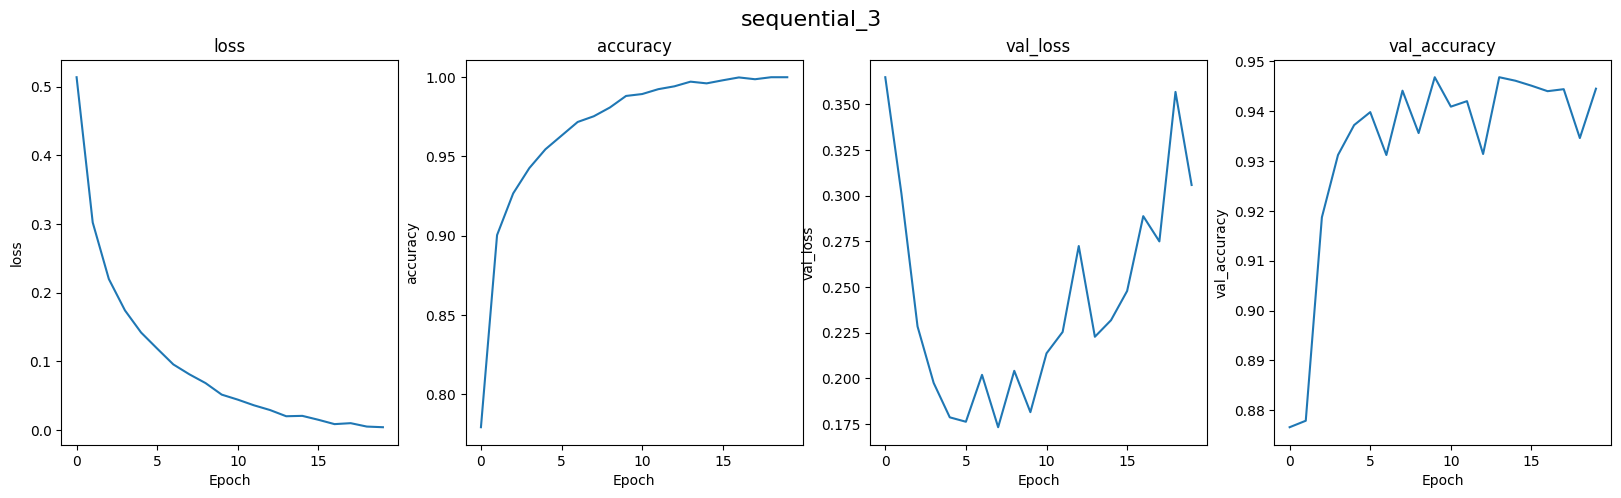

In [83]:
tensor_toolbox.draw_training_history(history=history)


In [84]:
epochs = 20
for epoch in range(1, epochs+1):
    print(f"Epoch {epoch}/{epochs}")
    loss, accu = torchtrain(torchmodel, train_dataloader, optimizer, loss_fn)
    print(f"Train -- Accuracy: {accu} | Loss: {loss}")
    loss, accu = torchtest(torchmodel, val_dataloader, loss_fn)
    print(f"Validation -- Accuracy: {accu} | Loss: {loss}")

#TODO: Find a way to print more interesting output that takes less space.

Epoch 1/20
Train -- Accuracy: 0.7359333333333333 | Loss: 0.594515093199412
Validation -- Accuracy: 0.8839 | Loss: 0.29839366059303285
Epoch 2/20
Train -- Accuracy: 0.915 | Loss: 0.22677654213110607
Validation -- Accuracy: 0.8879 | Loss: 0.29463234496116636
Epoch 3/20
Train -- Accuracy: 0.9471333333333334 | Loss: 0.15247197965780893
Validation -- Accuracy: 0.8846 | Loss: 0.31492095851898194
Epoch 4/20
Train -- Accuracy: 0.953 | Loss: 0.13654861183961234
Validation -- Accuracy: 0.8833 | Loss: 0.3139479031085968
Epoch 5/20
Train -- Accuracy: 0.9844666666666667 | Loss: 0.06470541444818179
Validation -- Accuracy: 0.8833 | Loss: 0.3799421772480011
Epoch 6/20
Train -- Accuracy: 0.9915333333333334 | Loss: 0.039785741583506264
Validation -- Accuracy: 0.8808 | Loss: 0.43085006585121155
Epoch 7/20
Train -- Accuracy: 0.9953333333333333 | Loss: 0.024157497598727543
Validation -- Accuracy: 0.8703 | Loss: 0.5348481232643127
Epoch 8/20
Train -- Accuracy: 0.9976 | Loss: 0.01443783285021782
Validation -

**Listing 4.8: Plotting the training and validation loss**

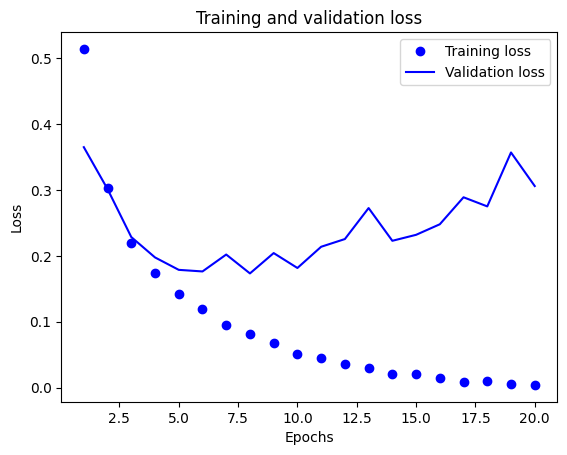

In [85]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Listing 4.9: Plotting the training and validation accuracy**

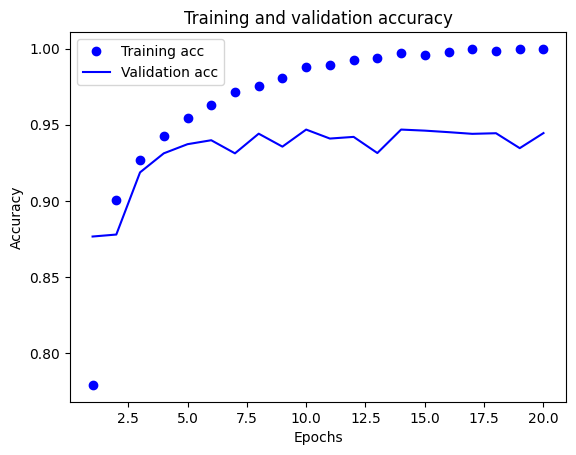

In [86]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Listing 4.10: Retraining a model from scratch**

In [87]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.fit(np.concatenate((x_train, x_val)), np.concatenate((y_train, y_val)), epochs=4, batch_size=512,
          callbacks=[TqdmCallback(verbose=1)], verbose=0)
results = model.evaluate(x_test, y_test)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

782/782 [==============================] - 1s 577us/step - loss: 0.3006 - accuracy: 0.8812


In [92]:
# Let's create new dataloaders to iterate over the whole training data (training+val) and
# the test data.
test_dataset = []
train_dataset = []
for i in range(len(x_test)):
   test_dataset.append([x_test[i].astype("float32"), y_test[i].astype("float32")])
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=512)
for i in range(len(x_train)):
    train_dataset.append([x_train[i].astype("float32"), y_train[i].astype("float32")])
for i in range(len(x_val)):
    train_dataset.append([x_val[i].astype("float32"), y_val[i].astype("float32")])
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=512)
# The torch model peaks in validation metrics at the second iteration! That's actually crazy.
epochs = 2
# Re-initialize the model, optimizer and loss object:
torchmodel = TorchModel()
optimizer = torch.optim.RMSprop(torchmodel.parameters())
loss_fn = torch.nn.BCELoss() 

for epoch in range(1, epochs+1):
    print(f"Epoch {epoch}/{epochs}")
    loss, accu = torchtrain(torchmodel, train_dataloader, optimizer, loss_fn)
    print(f"Train -- Accuracy: {accu} | Loss: {loss}")

loss, accu = torchtest(torchmodel, test_dataloader, loss_fn)
print(f"Test -- Accuracy: {accu} | Loss: {loss}") # Hell yeah! We happy

Epoch 1/2
Train -- Accuracy: 0.75624 | Loss: 0.5535380901145935
Epoch 2/2
Train -- Accuracy: 0.91424 | Loss: 0.22545754675388335
Test -- Accuracy: 0.88356 | Loss: 0.28983879580020905


### Using a trained model to generate predictions on new data

In [93]:
tensor_toolbox.tensor_info(model.predict(x_test), "Keras predictions")

782/782 [==============================] - 1s 531us/step
==================== Keras predictions | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (25000, 1) | nDims: 2 | dtype: float32
Content: [1.7165101e-01 9.9946529e-01 8.0524588e-01 6.8572801e-01 9.1059357e-01
 7.5883859e-01 9.9898380e-01 3.7931222e-03 9.4140583e-01 9.7823679e-01
 9.0060568e-01 3.2638672e-03 4.3134154e-05 1.4945872e-02 9.8852611e-01
 7.7148843e-06 8.5460758e-01 8.1273705e-01 1.1065808e-03 3.0376222e-02]
... (showing only the first 20 elements)



In [94]:
index = 751
print(read_review(train_data[index], word_index))
x = vectorize_sequences([test_data[index]])
yhat = model.predict(x)
print(f"Prediction: {'Positive'if yhat[0] > 0.5 else 'Negative'} | Confidence: {yhat[0]}")

? this is jackie chan's best film and my personal favourite after the disappointing u s made 'the ? directed by james ? jackie took the concept and placed it slap bang into hong kong this is also probably ? most violent movie with the audience cringing at the bone breaking stunts br br the action is fast and furious jackie and his crew really did put max effort into the fight design bones were broken and blood ? in the process of making this film as you'll see in the credits br br the script is a simple cops and robbers affair nothing special after all it was written around the action i must say that the english version has some dodgy dubbing but it shouldn't put you off too much br br so get the ? round crack open the beers and enjoy by the way the film was ? ? ? by the stunt crew why i'll let you find out for yourself
1/1 [==============================] - 0s 23ms/step
Prediction: Positive | Confidence: [0.941146]


### Further experiments

In [ ]:
# TODO: I would love to streamline this kind of network development. It gets kind of crammed tho...

In [ ]:
model1 = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model1")
model1.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

model2 = keras.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model2")
model2.compile(optimizer="rmsprop",
              loss="mse",
              metrics=["accuracy"])

model3 = keras.Sequential([
    layers.Dense(16, activation="tanh"),
    layers.Dense(1, activation="sigmoid")
], name="model3")
model3.compile(optimizer="rmsprop",
              loss="mse",
              metrics=["accuracy"])
model4 = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model4")
model4.compile(optimizer="rmsprop",
              loss="mse",
              metrics=["accuracy"])

model5 = keras.Sequential([
    layers.Dense(32, activation="tanh"),
    layers.Dense(1, activation="sigmoid")
], name="model5")
model5.compile(optimizer="rmsprop",
              loss="mse",
              metrics=["accuracy"])

model6 = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="tanh"),
    layers.Dense(1, activation="sigmoid")
], name="model6")
model6.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])


In [ ]:
# This function is kind of cool tho.
tensor_toolbox.keras_comparer([model1, model2, model3, model4, model5, model6], X_train=x_train, y_train=y_train, X_test=x_test, y_test=y_test, val_data=(x_val, y_val), epochs=10, batch_size=512)

### Wrapping up

## Classifying newswires: A multiclass classification example

### The Reuters dataset

**Listing 4.11: Loading the Reuters dataset**

In [ ]:
from tensorflow.keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000)
# More list arrays

**Listing 4.12: Decoding newswires back to text**

In [ ]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = " ".join([reverse_word_index.get(i - 3, "?") for i in
    train_data[0]])

In [ ]:
tensor_toolbox.tensor_info(train_labels, "train_labels", image=False)
# Each category corresponds to a newswire topic.

### Preparing the data

**Listing 4.13: Encoding the input data**

In [ ]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
tensor_toolbox.tensor_info(x_train, "x_train", image=False)
tensor_toolbox.tensor_info(x_test, "x_test", image=False)
# As in the previous case, the concept of order is lost.

**Listing 4.14: Encoding the labels**

In [ ]:
def to_one_hot(labels, dimension=46): # 46 categories
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results
y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)
tensor_toolbox.tensor_info(y_train, "y_train", image=False)

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)
tensor_toolbox.tensor_info(y_train, "y_train", image=False)
# Scikit-learn has a similar function called LabelEncoder

### Building your model

**Listing 4.15: Model definition**

In [ ]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])
model.build(input_shape=(512, 10000))
model.summary()

In [ ]:
from torch import nn
import torch.nn.functional as F # Contains the softmax function

class TorchModel (nn.Module):
    def __init__(self):
        super(TorchModel, self).__init__()
        # Using LazyLinears again. I could explicitly define the size.
        self.fc1 = nn.LazyLinear(64)
        self.fc2 = nn.LazyLinear(64)
        self.fc3 = nn.LazyLinear(46)

    def forward(self, X):
        X = torch.relu(self.fc1(X))
        X = torch.relu(self.fc2(X))
        return F.softmax(self.fc3(X), dim=1)


In [ ]:
torchmodel = TorchModel()
# This is pretty nice.
from torchsummary import summary
summary(torchmodel, input_size=(512, 10000))

**Listing 4.16: Compiling the model**

In [ ]:
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
import torch.optim as optim

# RMSprop, as in Keras.
# When you pass it model.parameters(), it gets the reference and knows
# how to update them. It's very cool.
optimizer = optim.RMSprop(torchmodel.parameters())
loss_fn = nn.CrossEntropyLoss()

def torchtrain(train_dataloader, model, loss_fn, optimizer):
    model.train() # We're training you!
    total_loss = 0.0
    correct = 0
    samples = 0

    for X, y in train_dataloader:
        y_hat = model(X)
        loss = loss_fn(y_hat, y)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (torch.argmax(y_hat, dim=1) == y).sum().item()
        samples += len(y)
    print(f"correct {correct} samples {samples}")
    avg_loss = total_loss / len(train_dataloader.dataset)
    return avg_loss, correct / samples

def torchtest(test_dataloader, model, loss_fn):
    model.eval()
    total_loss = 0.0
    correct = 0
    samples = 0

    with torch.no_grad():
        for X, y in test_dataloader:
            y_hat = model(X)
            loss = loss_fn(y_hat, y)

            total_loss += loss.item()
            correct += (torch.argmax(y_hat) == y).sum().item()
            samples += len(y)
    avg_loss = total_loss / len(test_dataloader.dataset)
    return avg_loss, correct / samples


### Validating your approach

**Listing 4.17: Setting aside a validation set**

In [ ]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]
# With sklearn:
partial_x_train, x_val, partial_y_train, y_val = train_test_split(x_train, y_train,
                                                  test_size=1000)
# I'm not a big fan of the names, but it's aight.

In [ ]:
# DataLoaders for torch:
train_dataset = []
val_dataset = []
for i in range(len(partial_x_train)):
    train_dataset.append([partial_x_train[i].astype("float32"), partial_y_train[i].astype("float32")])
for i in range(len(x_val)):
    val_dataset.append([x_val[i].astype("float32"), y_val[i].astype("float32")])

train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=512)
val_dataloader = torch.utils.data.DataLoader(val_dataset, shuffle=False, batch_size=512)

**Listing 4.18: Training the model**

In [ ]:
from tqdm.keras import TqdmCallback
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[TqdmCallback(verbose=1)],
                    verbose=0)

In [ ]:

epochs = 20
for epoch in range(1, epochs+1):
    print(f"Epoch {epoch}/{epochs}")
    loss, accu = torchtrain(train_dataloader, torchmodel, loss_fn, optimizer)
    print(f"Train -- Accuracy: {accu} | Loss: {loss}")
    loss, accu = torchtest(val_dataloader, torchmodel, loss_fn)
    print(f"Validation -- Accuracy: {accu} | Loss: {loss}")


**Listing 4.19: Plotting the training and validation loss**

In [ ]:
tensor_toolbox.draw_training_history(history=history)

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Plotting the training and validation accuracy**

In [ ]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Retraining a model from scratch**

In [ ]:
model = keras.Sequential([
  layers.Dense(64, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, # This x_train contains both the training and the validation sets. That's 
          # kind of annoying in my opinion.
          y_train,
          epochs=9,
          batch_size=512)
results = model.evaluate(x_test, y_test)

In [ ]:
results

In [ ]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
hits_array.mean()

### Generating predictions on new data

In [ ]:
predictions = model.predict(x_test)

In [ ]:
predictions[0].shape

In [ ]:
np.sum(predictions[0])

In [ ]:
np.argmax(predictions[0])

### A different way to handle the labels and the loss

In [ ]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [ ]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

### The importance of having sufficiently large intermediate layers

**A model with an information bottleneck**

In [ ]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

### Further experiments

### Wrapping up

## Predicting house prices: A regression example

### The Boston Housing Price dataset

**Loading the Boston housing dataset**

In [ ]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [ ]:
train_data.shape

In [ ]:
test_data.shape

In [ ]:
train_targets

### Preparing the data

**Normalizing the data**

In [ ]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

### Building your model

**Model definition**

In [ ]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

### Validating your approach using K-fold validation

**K-fold validation**

In [ ]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

In [ ]:
all_scores

In [ ]:
np.mean(all_scores)

**Saving the validation logs at each fold**

In [ ]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

**Building the history of successive mean K-fold validation scores**

In [ ]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

**Plotting validation scores**

In [ ]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

**Plotting validation scores, excluding the first 10 data points**

In [ ]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

**Training the final model**

In [ ]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

In [ ]:
test_mae_score

### Generating predictions on new data

In [ ]:
predictions = model.predict(test_data)
predictions[0]

### Wrapping up

## Summary